# Descriptive title that follows notebook filename <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages used for the analysis.

In [40]:
%matplotlib inline

import os
import dask
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
from odc.ui import select_on_a_map
from datacube.utils.geometry import CRS
from dask.utils import parse_bytes
from datacube.utils.rio import configure_s3_access
from datacube.utils.dask import start_local_dask
from odc.algo import fmask_to_bool, to_f32, from_float, xr_geomedian, keep_good_only

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_datahandling import load_ard

def run_filmstrip_app(time_range,
                      time_step,
                      tide_range,
                      max_cloud=50,
                      resolution=(-30, 30),
                      size_limit=100):
    
    # Configure dashboard link to go over proxy
    dask.config.set({"distributed.dashboard.link":
                     os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"});

    # Figure out how much memory/cpu we really have (those are set by jupyterhub)
    mem_limit = int(os.environ.get('MEM_LIMIT', '0'))
    cpu_limit = float(os.environ.get('CPU_LIMIT', '0'))
    cpu_limit = int(cpu_limit) if cpu_limit > 0 else 4
    mem_limit = mem_limit if mem_limit > 0 else parse_bytes('8Gb')

    # Leave 4Gb for notebook itself
    mem_limit -= parse_bytes('4Gb')

    # Close previous client if any, so that one can re-run this cell without issues
    client = locals().get('client', None)
    if client is not None:
        client.close()
        del client

    client = start_local_dask(n_workers=1,
                              threads_per_worker=cpu_limit, 
                              memory_limit=mem_limit)
    display(client)

    # Configure GDAL for s3 access 
    configure_s3_access(aws_unsigned=True,  # works only when reading public resources
                        client=client);

    
    # Plot interactive map to select area
    geopolygon = select_on_a_map(height='600px', 
                                 center=(-33.9719, 151.1934),zoom=12)

    # Test size
    area = (geopolygon.to_crs(crs = CRS('epsg:3577')).area / 
            (size_limit * 1000000))
    radius = np.round(np.sqrt(size_limit), 1)
    if area > size_limit: 
        print(f'Warning: Your selected area is {area:.00f} square kilometers. \n'
              f'Please select an area of less than {size_limit} square kilometers (e.g. '
              f'{radius} x {radius} km) . \nTo select a smaller area, re-run the cell above '
              f'and draw a new polygon.')
        
    else:
        
        query = {'time': time_range,
                 'geopolygon': geopolygon,
                 'output_crs': 'epsg:3577',
#                  'resampling': {'*': 'average', 'fmask': 'nearest'},
                 'gqa_iterative_mean_xy': [0, 1],
                 'cloud_cover': [0, max_cloud],
                 'resolution': resolution}

        ds = load_ard(dc=dc, 
                      measurements=['nbart_blue', 'nbart_green', 'nbart_red'],  #, 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
                      min_gooddata=0.0,
                      products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
                      lazy_load=True,
                      **query)
        
        # Calculate tides for each timestep in the satellite dataset
        from dea_coastaltools import tidal_tag
        ds = tidal_tag(ds=ds, tidepost_lat=None, tidepost_lon=None)
        min_tide, max_tide = ds.tide_height.quantile(tide_range)
        ds = ds.sel(time = (ds.tide_height >= min_tide) & 
                      (ds.tide_height <= max_tide))
        
#         return ds

        ds_geomedian = (ds
              .drop('tide_height')
              .resample(time=time_step, closed='left', label='left')
              .apply(lambda ds_subset: 
                     xr_geomedian(ds_subset, 
                                  num_threads=1,  # disable internal threading, dask will run several concurrently
                                  eps=0.2 * (1 / 10_000),  # 1/5 pixel value resolution
                                  nocheck=True)))  # disable some checks inside geomedian library that use too much ram

        print('\nGenerating filmstrip plots... (this may take several minutes)')
        ds_geomedian = ds_geomedian.compute()

        # Reset CRS
        ds_geomedian.attrs['crs'] = ds.crs

        # Plot RGB
        rgb(ds_geomedian, col='time')

        return ds_geomedian






In [2]:
# !pip install --user --extra-index-url="https://packages.dea.ga.gov.au" hdstats
# !pip install --user --extra-index-url="https://packages.dea.ga.gov.au" odc-algo

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app='DEA_notebooks_template')

### Analysis parameters

The following cell sets important required parameters for the analysis:

* `time_range`: The date range to analyse (e.g. `('1988', '2018')`)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare (e.g. `1Y` will generate one filmstrip plot for every year in the dataset; `5Y` will generate one plot for each five year period etc).

Optional parameters:

* `max_cloud`: This parameter allows you to exclude satellite images with excessive cloud. The fault is `50`, which will keep all images with less than 50% cloud.
* `resolution`: The spatial resolution to load data. The fault is `(-30, 30)`, which will load data at 30 m pixel resolution. Increasing this (e.g. to `(-100, 100)`) can be useful for loading large spatial extents.

**If running the notebook for the first time**, keep the default settings below. This will demonstrate how the analysis works and provide meaningful results. 


In [73]:
# Required parameters
time_range = ('2000', '2019')
time_step = '1Y'
tide_range = (0.0, 0.2)

# Optional parameters
max_cloud = 50
resolution = (-30, 30)

## Select location and generate filmstrips
Run the following cell to start the analysis. 
This will plot an interactive map that is used to select the area to load satellite data for.

Select the `Draw a rectangle` or `Draw a polygon` tool on the left of the map, and draw a shape around the area you are interested in.

When you are ready, press the green `done` button on the top right of the map. 
This will start loading the data, and then generate a filmstrips plot.

> Depending on the size of the area you select, this step can take **several minutes to complete**.
To keep load times reasonable, select an area **smaller than 100 square kilometres** in size (this limit can be overuled by supplying the `size_limit` parameter in the `run_filmstrip_app` function below).

> To check the status of the data load, click the **Dashboard** link under **Client** below.


/usr/local/lib/python3.6/dist-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:37015 Dashboard: /user/robbibt/proxy/39373/status,Cluster Workers: 1 Cores: 8 Memory: 60.42 GB


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Loading ga_ls5t_ard_3 data
    169 observations
    Applying pixel quality mask
Loading ga_ls7e_ard_3 data
    522 observations
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    154 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 845 observations as a dask array
Setting tide modelling location from dataset centroid: 150.86, -34.53

Generating filmstrips... (this may take several minutes)


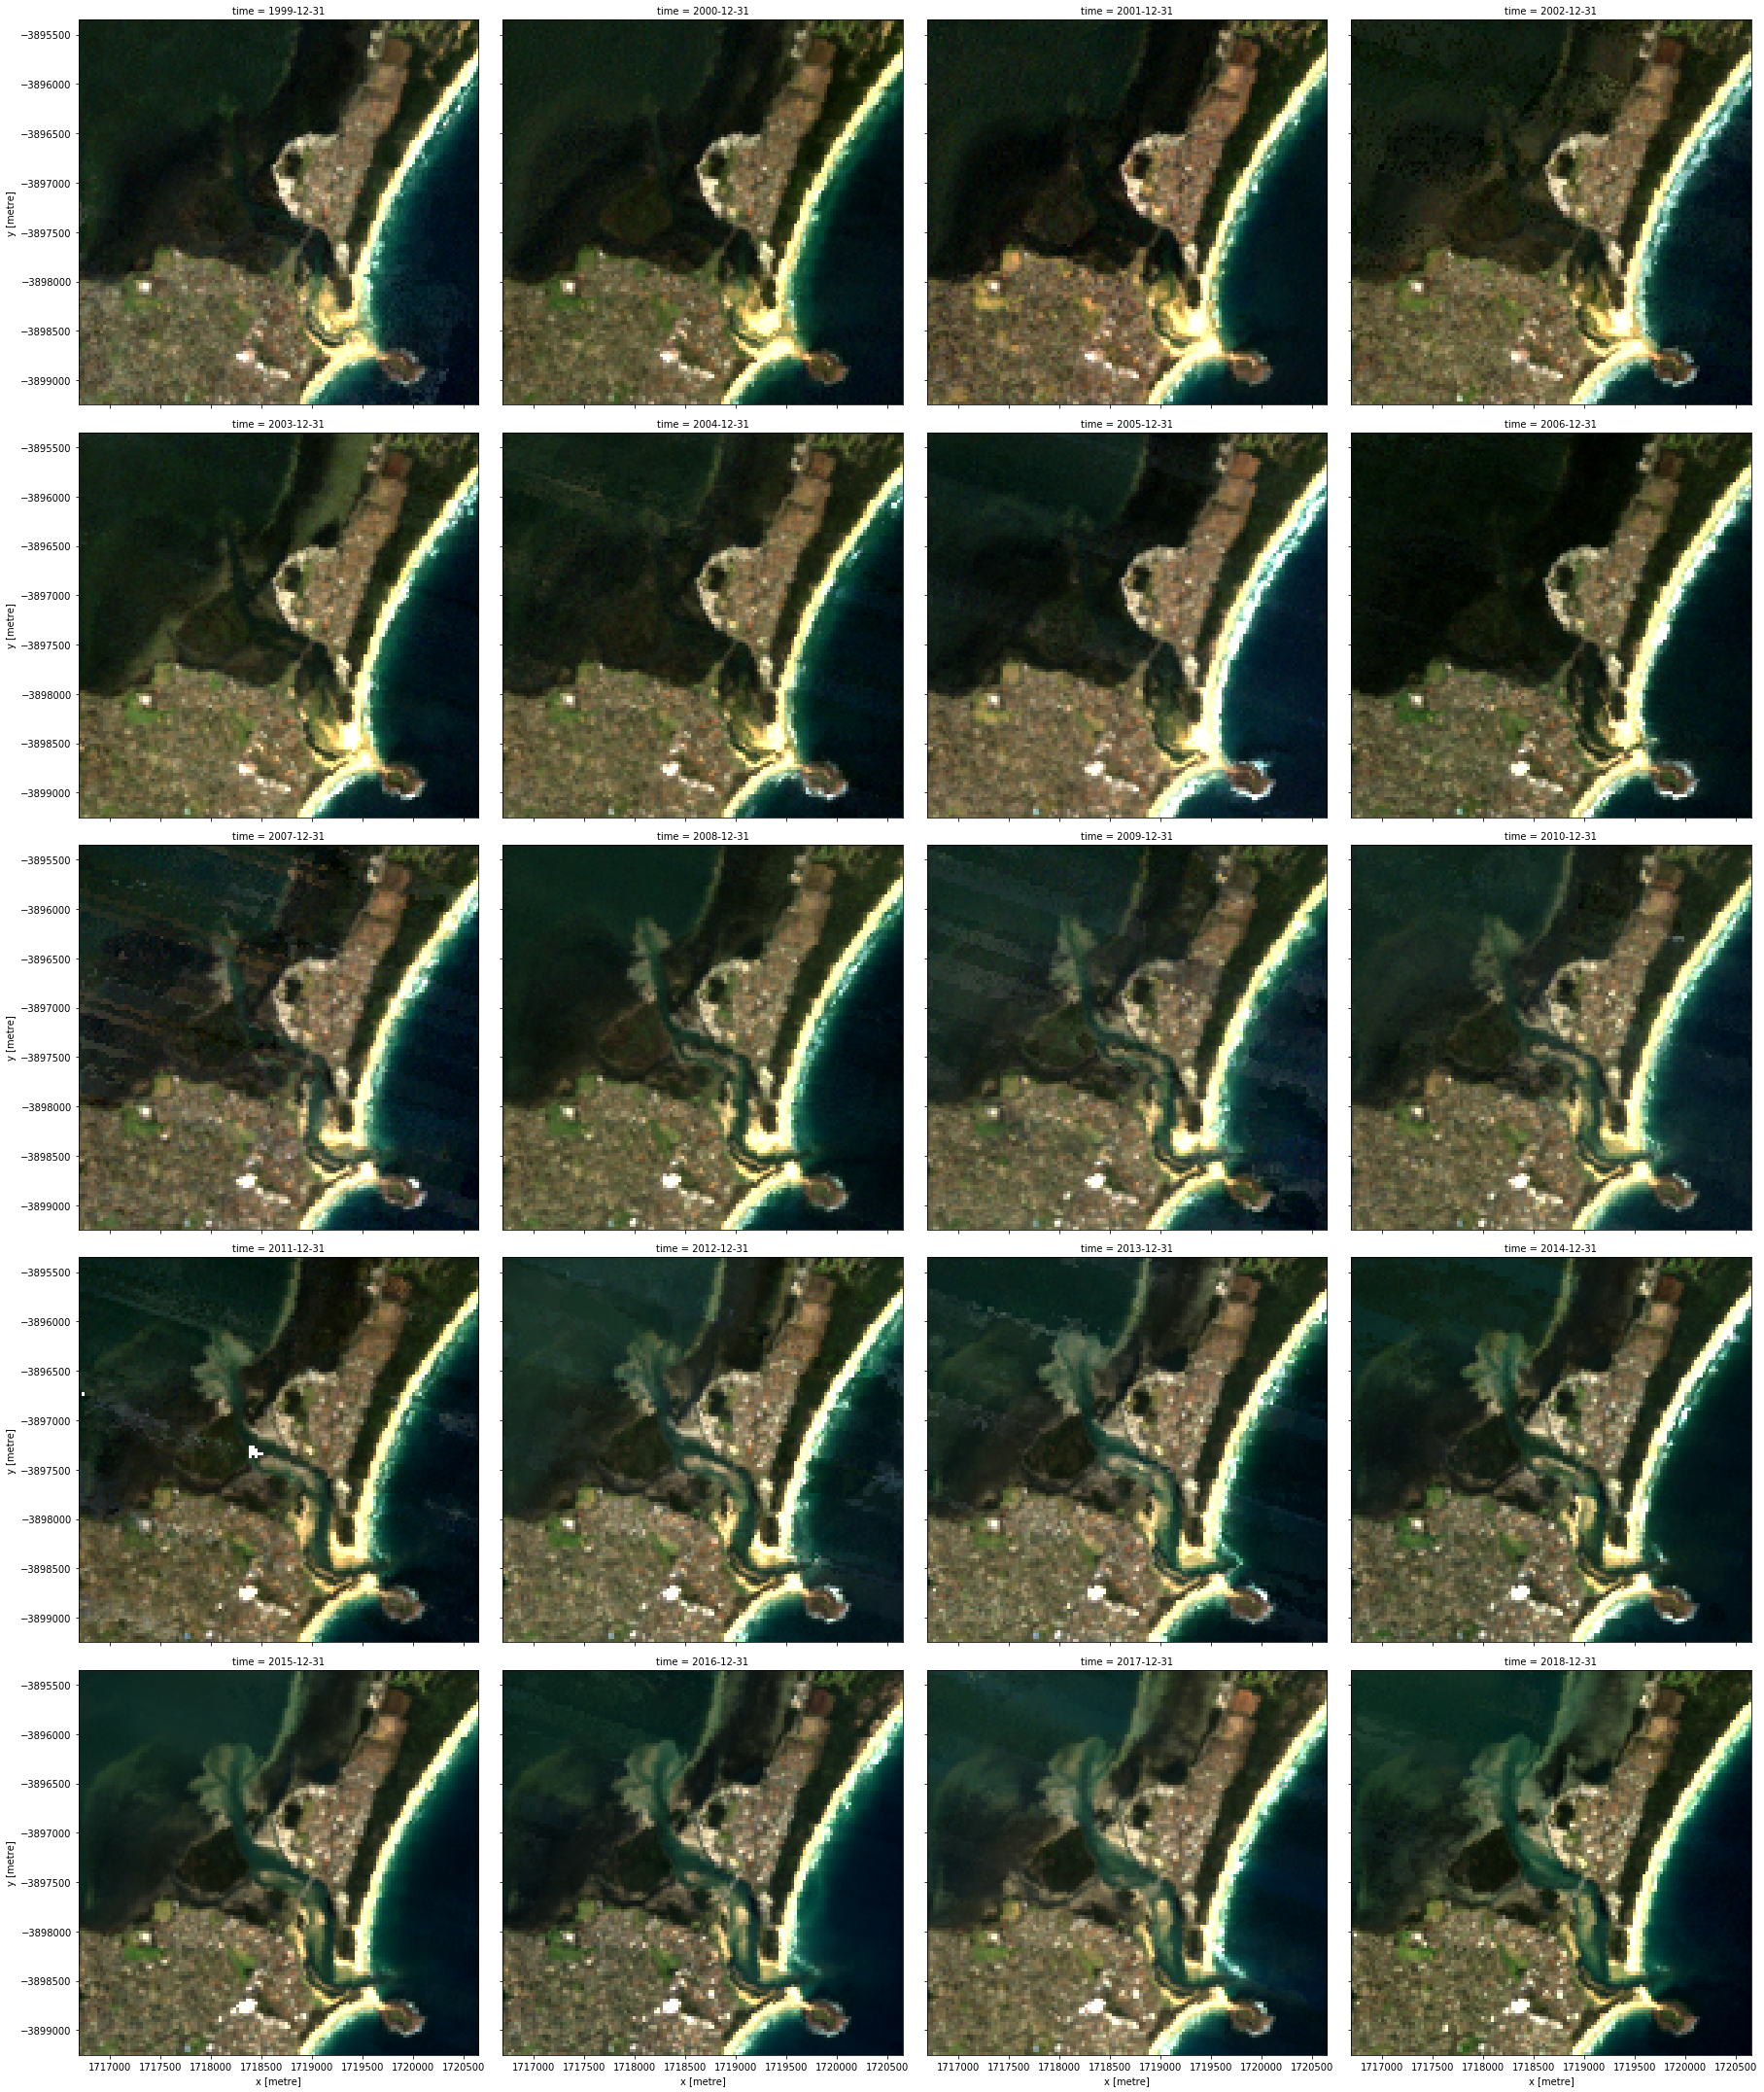

In [75]:
output_data = run_filmstrip_app(time_range,
                                time_step,
                                tide_range,
                                max_cloud,
                                resolution)

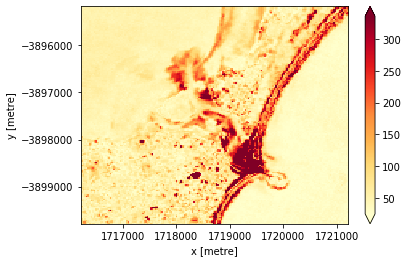

In [72]:
(output_data).to_array().std(dim=['time']).mean(dim='variable').plot.imshow(robust=True, cmap='viridis')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)